# Final Feature Exploration

Having done initial exploration for all of the features in the dataset, we now collate the features that we identified as potentially promising in helping to predict/explain goals scored. We then perform more data exploration with the promising features to either perform further feature engineering, or to eliminate additional features. 

In [10]:
import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
#we also load this in, just in case we need any deleted features for feature engineering purposes 
att_explore = pd.read_csv('att_explore.csv')

In [47]:
#load the att_explore dataframe in 
att_final = pd.read_csv('att_explore_original.csv')
att_final.head()

,Unnamed: 0,Player ID,Day,Matchweek,Venue,Result,Team,Opponent,Start,Position,...,kickoff_time,own_goals,saves,selected,threat,total_points,transfers_balance,transfers_in,transfers_out,value
0,10000,140,Sun,32,Away,L 1–2,Crystal Palace,Leicester City,Y,DM,...,2022-04-10 13:00:00+00:00,0,0,6955,36.0,2,27,343,316,54
1,24977,340,Sat,29,Away,L 1–2,Bournemouth,Liverpool,N,LW,...,2020-03-07 12:30:00+00:00,0,0,24392,0.0,1,-359,133,492,52
2,37756,498,Sun,37,Away,D 0–0,Huddersfield,Manchester City,Y,CM,...,2018-05-06 12:30:00+00:00,0,0,10349,0.0,3,-47,129,176,44
3,18759,262,Sun,34,Away,D 2–2,Southampton,Brighton,N,LM,...,2022-04-24 13:00:00+00:00,0,0,19229,5.0,1,-1446,288,1734,58
4,168,3,Sun,38,Home,W 5–0,Manchester City,Norwich City,Y*,LM,...,2020-07-26 15:00:00+00:00,0,0,801163,101.0,3,198047,228466,30419,75


# EDA Functions

In [218]:
def grouped_boxplot (df, feature, group_feature):
    plt.figure()
    df.boxplot(column = feature, by = group_feature, grid = False, showmeans = True)
    plt.title(f'Box Plot of {feature} vs {group_feature}')
    plt.suptitle('')
    plt.xlabel(group_feature)
    plt.ylabel(feature)
    plt.show()

In [217]:
def category_boxplot (df, feature, group_feature, text_diff = 2, dropna = False):
    #create figure
    plt.figure()
    
    #prep data by grouping into two categories
    if dropna == False:
        data = [df[df[group_feature] == 0][feature],   # Goals == 0
            df[df[group_feature] != 0][feature]]   # Goals != 0
    else: 
        data = [df[df[group_feature] == 0][feature].dropna(),   # Goals == 0
            df[df[group_feature] != 0][feature].dropna()]   # Goals != 0
    
    #create boxplot
    plt.boxplot(data, labels = [f'0 {group_feature}', f'Non-zero {group_feature}'], showmeans = True)
    plt.title(f'Box Plot of {feature} vs {group_feature} Category')
    plt.xlabel(f'{group_feature} Category')
    plt.ylabel(feature)
    
    #print mean/median 
    for i in range(len(data)):
        # Median (the horizontal line in the box)
        median = np.median(data[i])
        plt.text(i + 1.2, median, f'Median: {median:.2f}', ha='left', va='bottom', color='blue')

        # Mean (the green triangle in the boxplot)
        mean = np.mean(data[i])
        plt.text(i + 1.2, mean + text_diff, f'Mean: {mean:.2f}', ha='left', va='top', color='green')

    plt.show()

## Feature Summaries

### General Features

In [48]:
#remove the Unnamed:0 column
att_final = att_final.drop(columns=['Unnamed: 0'])

#removing observations where 'Minutes Played = 0'
att_final = att_final[att_final['Minutes Played'] != 0]
att_final.head()

,Player ID,Day,Matchweek,Venue,Result,Team,Opponent,Start,Position,Minutes Played,...,kickoff_time,own_goals,saves,selected,threat,total_points,transfers_balance,transfers_in,transfers_out,value
0,140,Sun,32,Away,L 1–2,Crystal Palace,Leicester City,Y,DM,90,...,2022-04-10 13:00:00+00:00,0,0,6955,36.0,2,27,343,316,54
1,340,Sat,29,Away,L 1–2,Bournemouth,Liverpool,N,LW,23,...,2020-03-07 12:30:00+00:00,0,0,24392,0.0,1,-359,133,492,52
2,498,Sun,37,Away,D 0–0,Huddersfield,Manchester City,Y,CM,90,...,2018-05-06 12:30:00+00:00,0,0,10349,0.0,3,-47,129,176,44
3,262,Sun,34,Away,D 2–2,Southampton,Brighton,N,LM,25,...,2022-04-24 13:00:00+00:00,0,0,19229,5.0,1,-1446,288,1734,58
4,3,Sun,38,Home,W 5–0,Manchester City,Norwich City,Y*,LM,84,...,2020-07-26 15:00:00+00:00,0,0,801163,101.0,3,198047,228466,30419,75


There were also a series of features pertaining to the more defensive side of the game which we instantly ruled out from being potentially useful in explaining either goals or assists. We will remove these features right away. 

In [49]:
att_final = att_final.drop(columns = ['Tackles Won', 'Defensive Third Tackles', 'Middle Third Tackles', 'Attacking Third Tackles', 'Dribblers Tackled', 'Dribblers Tackled Attempts'
                                      , 'Challenges Lost', 'Shots Blocked', 'Passes Blocked', 'Clearances', 'Defensive Errors', 'Miscontrols', 'Dispossessed'])

From 'General_FeatureExplore', the following features were identified as promising. 
* Venue - We didn't really see a significant difference in the proportion of goalscoring observations when comparing 'Home and 'Away', but we know contextually that the venue is generally an important feature, so we will keep it for now

In [50]:
#we drop 'Day' and 'Matchweek' from att_final
att_final = att_final.drop(columns = ['Day', 'Matchweek'])
att_final.head()

,Player ID,Venue,Result,Team,Opponent,Start,Position,Minutes Played,Goals,Assists,...,kickoff_time,own_goals,saves,selected,threat,total_points,transfers_balance,transfers_in,transfers_out,value
0,140,Away,L 1–2,Crystal Palace,Leicester City,Y,DM,90,0,0,...,2022-04-10 13:00:00+00:00,0,0,6955,36.0,2,27,343,316,54
1,340,Away,L 1–2,Bournemouth,Liverpool,N,LW,23,0,0,...,2020-03-07 12:30:00+00:00,0,0,24392,0.0,1,-359,133,492,52
2,498,Away,D 0–0,Huddersfield,Manchester City,Y,CM,90,0,0,...,2018-05-06 12:30:00+00:00,0,0,10349,0.0,3,-47,129,176,44
3,262,Away,D 2–2,Southampton,Brighton,N,LM,25,0,0,...,2022-04-24 13:00:00+00:00,0,0,19229,5.0,1,-1446,288,1734,58
4,3,Home,W 5–0,Manchester City,Norwich City,Y*,LM,84,0,0,...,2020-07-26 15:00:00+00:00,0,0,801163,101.0,3,198047,228466,30419,75


* Result - We transformed this feature by splitting it into two features. 'Outcome' (whether or not the game being played in ended up in a Win, Loss or Draw) and 'Score' (the final score of the game). We then further transformed the 'Score' feature into 'Team Goals', by looking at the number of goals scored by the team in that game. We ended up seeing that the number of goals conceded in a game didn't really matter. Therefore, we will get rid of the 'Score' feature, and only keep 'Outcome' and 'Team Goals'. 

In [51]:
#create new dataframe with just result and goals 
result_transform = att_final[['Result']].copy()

#strip the result column of any whitespace, to make it easier to process the string 
result_transform.loc[:, 'Result'] = result_transform['Result'].str.strip()

#use str.extract method to extract the relevant strings from the result column. the purpose of this is to create two new features (outcome and score)
result_transform[['Outcome', 'Score']] = result_transform['Result'].str.extract(r'([LWD])\s+(\d+[–-]\d+)')

#drop the result column, as we no longer need this 
result_transform = result_transform.drop('Result', axis = 1)

#replace the dash in the score column with a hyphen, to make it easier to work with in the future 
result_transform['Score'] = result_transform['Score'].str.replace('\u2013', '-', regex = True)

#create 'Team Goals' column
result_transform['Team Goals'] = result_transform['Score'].str.split('-').str[0].astype(int)

#remove 'Score' column 
result_transform = result_transform.drop(columns = ['Score'])

#append back onto att_final
att_final = pd.concat([att_final, result_transform], axis = 1)

#remove 'Result' from att_final
att_final = att_final.drop(columns = ['Result'])
att_final.head()

,Player ID,Venue,Team,Opponent,Start,Position,Minutes Played,Goals,Assists,Penalties Scored,...,saves,selected,threat,total_points,transfers_balance,transfers_in,transfers_out,value,Outcome,Team Goals
0,140,Away,Crystal Palace,Leicester City,Y,DM,90,0,0,0,...,0,6955,36.0,2,27,343,316,54,L,1
1,340,Away,Bournemouth,Liverpool,N,LW,23,0,0,0,...,0,24392,0.0,1,-359,133,492,52,L,1
2,498,Away,Huddersfield,Manchester City,Y,CM,90,0,0,0,...,0,10349,0.0,3,-47,129,176,44,D,0
3,262,Away,Southampton,Brighton,N,LM,25,0,0,0,...,0,19229,5.0,1,-1446,288,1734,58,D,2
4,3,Home,Manchester City,Norwich City,Y*,LM,84,0,0,0,...,0,801163,101.0,3,198047,228466,30419,75,W,5


* Team - We saw that there were certain teams that were associated with higher proportions of goalscoring observations, where the teams in question are the stronger teams in the league. We should keep this feature, as they are useful identifiers for incorporating team statistics into the model. 

* Opponent - Once again, we saw that certain teams were associated with higher proportions of goalscoring observations, where the teams in question this time are the weaker teams in the league. We also did some feature transformation by looking at the relationship between goalscoring observations and the final league position of the opposing team. Here, we saw that there is a higher proportion of goalscoring observations when playing against teams at the bottom of the table, which is what we expected. 

* Start - We saw that observations that started games were associated with higher proportions of goalscoring observations. However, we need to transform this feature by combining Y and Y* entries, because Y* (which indicates that a player started the game as captain), doesn't really have a significant impact. 

In [52]:
#replacing all Y* entries with Y in 'Start' column 
att_final['Start'] = att_final['Start'].replace('Y*', 'Y')
att_final['Start'].unique()

array(['Y', 'N'], dtype=object)

* Position - We transformed this feature by first one-hot encoding into a range of positions (these positions are the unique positions that we could find). The reason we had to do this was because there was a large range of unique values in this column (this is because a player may have played multiple positions in a match, and this was recorded as such. For example, if a player started the game in DM, but moved to RM, then the position entry would be DM, RM.). We then further refined the entries by combining certain groups (so observations with a 1 in either LW or RW were marked as having a 1 in Wingers). We ended up transforming the 'Position' column into a series of one-hot encoded columns, with a 1 if the observation played in that position in that game, and a 0 otherwise. 

In [53]:
#manually inputting the position for these 3 observations, as they were missing
att_final.loc[12664, 'Position'] = 'FW'
att_final.loc[16504, 'Position'] = 'FW'
att_final.loc[25979, 'Position'] = 'RW'

#performing the one-hot encoding
positions = att_final['Position']
positions_df = pd.DataFrame(positions, columns = ['Position'])
positions_encode = positions_df['Position'].str.get_dummies(sep = ',')


#for any observation that has a 1 in 'RB', 'LB' or 'CB', we also enter 1 in 'Defender' 
positions_encode['Defender'] = positions_encode[['RB', 'LB', 'CB']].any(axis = 1).astype(int)
#we now remove 'RB', 'LB' and 'CB'
positions_encode = positions_encode.drop(columns = ['RB', 'CB', 'LB'])

#for any observation that has a 1 in 'DM' or 'CM', we also enter 1 in 'Midfielder' 
positions_encode['Midfielder'] = positions_encode[['DM', 'CM']].any(axis = 1).astype(int)
#we now remove 'DM' and 'CM'
positions_encode = positions_encode.drop(columns = ['DM', 'CM'])

#for any observation that has a 1 in 'LM' or 'RM', we also enter 1 in 'Wide Midfielder' 
positions_encode['Wide Midfielder'] = positions_encode[['LM', 'RM']].any(axis = 1).astype(int)
#we now remove 'LM' and 'RM'
positions_encode = positions_encode.drop(columns = ['LM', 'RM'])

#for any observation that has a 1 in 'LW' or 'RW', we also enter 1 in 'Winger' 
positions_encode['Winger'] = positions_encode[['LW', 'RW']].any(axis = 1).astype(int)
#we now remove 'LW' and 'RW'
positions_encode = positions_encode.drop(columns = ['LW', 'RW'])


#rename the 'AM' column 'Attacking Midfielder' 
positions_encode = positions_encode.rename(columns={'AM': 'Attacking Midfielder'})

#rename the 'FW' column 'Forward' 
positions_encode = positions_encode.rename(columns={'FW': 'Forward'})

#rename the 'WB' column 'Wingback' 
positions_encode = positions_encode.rename(columns={'WB': 'Wingback'})

#append back onto att_final
att_final = pd.concat([att_final, positions_encode], axis = 1)

#remove 'Position' from att_final
att_final = att_final.drop(columns = ['Position'])
att_final.head()

,Player ID,Venue,Team,Opponent,Start,Minutes Played,Goals,Assists,Penalties Scored,Penalties Attempted,...,value,Outcome,Team Goals,Attacking Midfielder,Forward,Wingback,Defender,Midfielder,Wide Midfielder,Winger
0,140,Away,Crystal Palace,Leicester City,Y,90,0,0,0,0,...,54,L,1,0,0,0,0,1,0,0
1,340,Away,Bournemouth,Liverpool,N,23,0,0,0,0,...,52,L,1,0,0,0,0,0,0,1
2,498,Away,Huddersfield,Manchester City,Y,90,0,0,0,0,...,44,D,0,0,0,0,0,1,0,0
3,262,Away,Southampton,Brighton,N,25,0,0,0,0,...,58,D,2,0,0,0,0,0,1,0
4,3,Home,Manchester City,Norwich City,Y,84,0,0,0,0,...,75,W,5,0,0,0,0,0,1,0


* Minutes Played - We know from contextual information that this is an important feature. However, we are unsure about the direct relationship between this feature and goals. We will keep this feature because it is useful to transform certain features into per90. We will need to keep this feature to do that. 

### Performance Features

* Penalties Attempted - We saw that players that attempted penalties in a game scored a goal almost 80% of the time. In other words, if we know a player is going to have a penalty attempt in a game, the probability of them scoring a goal is quite high. However, this isn't necessarily the most relevant information. We also saw that Penalty Success Rate (calculated as the proportion of Successful Penalties over Penalties Attempted) didn't necessarily provide any additional information. However, we did also do some feature engineering, which allowed us to mark certain Player ID's as 'Designated Penalty Takers'. We then saw that the proportion of goalscoring observations was much higher for the designated penalty takers, compared to the non-designated penalty takers. Based on this, we will include the 'Penalties Attempted' and 'Designated Penalty Taker' features. The 'Penalties Scored' feature will be removed for now. 

(As part of the 'Designated Penalty Takers' feature engineering, we also needed to add another feature called 'Season'. This is essentially just a simplified version of the kickoff_time feature, with the date and time of the match stripped away)


In [54]:
# Convert 'kickoff_time' to datetime
att_final['kickoff_time'] = pd.to_datetime(att_final['kickoff_time'])

# Function to determine the season
def determine_season(kickoff_time):
    month = kickoff_time.month
    year = kickoff_time.year
    if month >= 8:  # August to December
        return f'{year}-{year + 1}'  # Current year to next year
    else:  # January to July
        return f'{year - 1}-{year}'  # Previous year to current year

# Apply the function to create the 'season' column
att_final['Season'] = att_final['kickoff_time'].apply(determine_season)

In [55]:
#group observations by player ID and penalties attempted 
pen_group = att_final.groupby('Player ID', as_index = False)['Penalties Attempted'].sum()

#remove obs with 0 penalties attempted 
pen_group = pen_group[pen_group['Penalties Attempted'] > 0 ]

#create new dataframe which has 'kickoff_time', 'Season', 'penalties attempted' and 'team in it 
team_pens = att_final[['kickoff_time', 'Season', 'Penalties Attempted', 'Team']].copy()

#now we group by team and season to compute how many penalties were taken by each team in each season
team_pens_summary = team_pens.groupby(['Season', 'Team'], as_index=False)['Penalties Attempted'].sum()
team_pens_summary.rename(columns={'Penalties Attempted': 'Team Penalties'}, inplace=True)

#create empty dataframe
pen_prop = pd.DataFrame()

#loop through to get the Player ID and Penalties Attempted for each team in each season, filtering so that we only include observations with at 
#least 1 penalty taken 
for index, row in team_pens_summary.iterrows():
    team = row['Team']
    season = row['Season']
    
    filtered = att_final[(att_final['Season'] == season) & (att_final['Team'] == team) & (att_final['Penalties Attempted'] > 0)][['Player ID', 'Penalties Attempted']]
    filtered['Team'] = team
    filtered['Season'] = season
    pen_prop = pd.concat([pen_prop, filtered], ignore_index= True)

#adding a new column into pen_prop called 'Team Penalties' which merges the relevant information from team_pens_summary
pen_prop = pen_prop.merge(team_pens_summary, on=['Team', 'Season'], how='left')

#we now merge rows that have the same player ID, team and season together. For the rows that satisfy this, we sum the penalties attempted to 
#reflect the number of penalties a particular player ID took in a given season 
merged_penprop = pen_prop.groupby(['Team', 'Season', 'Player ID'], as_index=False).agg({
    'Penalties Attempted': 'sum',
    'Team Penalties': 'first'  
})
merged_penprop = merged_penprop.sort_values(by='Player ID')

#adding new column called Proportion of Team Penalties Taken
merged_penprop['Proportion of Team Penalties Taken'] = (
    merged_penprop['Penalties Attempted'] / merged_penprop['Team Penalties']
)

#final dataframe which merges the rows based on Player ID. Each row now corresponds to one unique player ID, the penalties attempted and team 
#penalties columns are now summed. The proportion is then recalculated 
penprop_summary = merged_penprop.groupby('Player ID').agg(
    Penalties_Attempted=('Penalties Attempted', 'sum'),
    Team_Penalties=('Team Penalties', 'sum')
).reset_index()

penprop_summary['Proportion of Team Penalties Taken'] = (
    penprop_summary['Penalties_Attempted'] / penprop_summary['Team_Penalties'])

#first off, we can probably include all player ID's with 100% team penalties taken as 'designated penalty takers'
desig_pen_takers = penprop_summary.loc[penprop_summary['Proportion of Team Penalties Taken'] == 1, 'Player ID'].tolist()

#we now look at the rest of the observations. let's remove the player ID's that are already included in desig_pen_takers from penprop_summary 
#for clarity 
penprop_summary = penprop_summary[~penprop_summary['Player ID'].isin(desig_pen_takers)]
penprop_summary = penprop_summary.sort_values(by='Penalties_Attempted', ascending=False)

#we now add the Player ID's of players that took more than 50% of their team's penalties 
additional_takers = penprop_summary.loc[penprop_summary['Proportion of Team Penalties Taken'] > 0.5, 'Player ID'].tolist()
desig_pen_takers.extend(additional_takers)

#we now remove the rows corresponding to the player ID's that we just added to desig_pen_takers
penprop_summary = penprop_summary[~penprop_summary['Player ID'].isin(desig_pen_takers)]

#construct 'Designated Penalty Taker' feature 
att_final['Designated Penalty Taker'] = att_final['Player ID'].isin(desig_pen_takers).astype(int)

* Shots - We saw that shots was a useful predictor of goals, which was what we expected. 
* Shots on Target - We also saw that SOT (Shots on Target) was a useful predictor of goals. Not only this, but we also saw that SOT is potentially a less noisy predictor of goals. In other words, it may be more valuable to use Shots on Target in the model instead of Shots. Finally, we saw that there was some correlation between these two features, but it wasn't strong enough to consider including only one of these features in the final list at the expense of the other. 
* Yellow/Red Cards - We saw that neither yellow nor red cards were good predictors of goals. Therefore, we should remove these features. 

In [56]:
#remove 'Result' from att_final
att_final = att_final.drop(columns = ['Yellow Cards', 'Red Cards'])

* Touches - We saw that the touches variable also wasn't particularly useful in explaining goals. This is primarily because more defensive minded players are likely to accumulate more touches, whereas the number of touches also varies amongst attacking players depending on the tactical system of the team and the role being played by the player. 

In [57]:
#remove 'Touches' from att_final
att_final = att_final.drop(columns = ['Touches'])

* Tackles, Interceptions and Blocks - All 3 of these defensive metrics were shown to have very little explanatory power for goals. We can remove these features as they are unlikely to be particularly useful to us. 

In [58]:
att_final = att_final.drop(columns = ['Tackles', 'Interceptions', 'Blocks'])

### Expected Data Features

* xG - We saw that the xG feature was a very good predictor of goals. This makes sense, based on our understanding of what xG measures 
* npxG - Similar to xG, npxG is also a good predictor of goals. The difference between these two features is that npxG doesn't include xG accumulated from penalties. We saw that the xG and npxG values were quite highly correlated with each other. Therefore, we would probably only want to include npxG in the model. However, we will keep both of these features for now, as they are both likely to be extremely useful in any model and/or exploratory analysis. 
* xAG - We saw that xAG offered very little explanatory power in relation to goals. However, it was quite useful in predicting assists. Therefore, we will remove this feature for now. 

In [59]:
att_final = att_final.drop(columns = ['xAG'])

### SCA/GCA Features

* Shot Creating Actions (SCA) - We saw originally that there appeared to be a positive relationship between SCA and Goals. However, we decided to look further by correcting the SCA value for each observation by the number of team goals in that game. Once we made this correction, we saw that the relationship between the corrected SCA and Goals was no longer present. Therefore, SCA as a metric can probably be discarded. 

In [60]:
att_final = att_final.drop(columns = ['Shot Creating Actions'])

* Other SCA Features - We saw that there wasn't anything particuarly useful amongst the other SCA features (these being Foul SCA, Live SCA, Shot SCA etc.) Therefore, we can probably discard them all. 

In [61]:
att_final = att_final.drop(columns = ['Live SCA', 'Deadball SCA', 'Take-on SCA', 'Shot SCA', 'Foul SCA', 'Defense SCA'])

* Goal Creating Actions (GCA) - The GCA feature exploration yielded a similar picture to what we saw when looking at SCA. Although there initially appeared to be some relationship between GCA and Goals, we discovered that this was probably due to the relatioship between GCA and Team Goals. The individual GCA features also didn't really offer much information. Therefore, we can probably discard them all. 

In [62]:
att_final = att_final.drop(columns = ['Goal Creating Actions', 'Live GCA', 'Deadball GCA', 'Take-on GCA', 'Shot GCA', 'Foul GCA', 'Defense GCA'])

### Passing Features

* Passes Attempted, Passes Completed and Pass Completion Percentage - The exploratory analysis showed that none of these 3 features were useful in predicting/explaining the number of goals scored. Therefore, we can remove them. 

In [63]:
att_final = att_final.drop(columns = ['Passes Attempted', 'Passes Completed'])

* Passing Distance - We also saw that passing distance was not a particularly useful feature in terms of predicting goals. We can also remove this feature. 

In [64]:
att_final = att_final.drop(columns = ['Passing Distance'])

* Progressive Passes and Progressive Passing Distance - Our exploration showed that neither the number of progressive passes nor the progressive passing distance accumulated were useful in explaining goals. Therefore, we can remove these features. 

In [65]:
att_final = att_final.drop(columns = ['Progressive Passes', 'Progressive Passing Distance'])

* Short/Medium/Long Passes - The data on the number of attempted short/medium/long passes as well as the number of completed short/medium/long passes were not particularly useful in explaining goals. We can remove these features. 

In [66]:
att_final = att_final.drop(columns = ['Short Passes Attempted', 'Short Passes Completed', 'Medium Passes Attempted',
                                      'Medium Passes Completed', 'Long Passes Attempted', 'Long Passes Completed'])

* Passes into the Final Third - We saw that the number of passes into the penalty area recorded wasn't necessarily that useful in explaining goals. We can remove this feature 

In [67]:
att_final = att_final.drop(columns = ['Passes into Final Third'])

* Passes into the Penalty Area - We saw that this feature was useful for explaining assists, but not so much for explaining goals. We can remove this feature. 

In [68]:
att_final = att_final.drop(columns = ['Passes into Penalty Area'])

* Crosses into the Penalty Area - This feature was not particularly useful at all, largely due to the fact that many of the observations had value equal to zero. Therefore, we should remove this feature. 

In [69]:
att_final = att_final.drop(columns = ['Crosses into Penalty Area'])

* Key Passes - Whilst this feature is an important one for predicting/explaining assists, it isn't particularly useful for goals. Therefore, we should remove this feature. 

In [70]:
att_final = att_final.drop(columns = ['Key Passes'])

* Live/Dead Pass - We saw that these features essentially reflected the information given by the passes completed feature. Therefore we can remove this feature 
* Free Kick Pass - This is essentially just a more refined version of dead pass, that doesn't include throw-ins/restarts/corners. Again, we didn't really find much value in this feature, so we can remove it 
* Throw ins Taken - Perhaps as expected, the number of throw ins taken by a player doesn't hold much value. We can remove this feature 
* Corners Taken - This feature perhaps has some value in predicting/explaining assists. However, it doesn't really help with goals. We can remove this feature. 

In [71]:
att_final = att_final.drop(columns = ['Live Pass', 'Dead Pass', 'Free Kick Pass', 'Throw Ins Taken', 'Corners Taken'])

* Through Balls - Whilst this feature does not hold any explanatory/predictive power when it comes to goals, it may be slightly useful in helping predict/explain assists. Despite this, we can remove this feature for now. 
* Passes Offside - The exploratory analysis showed that this feature wasn't useful for predicting either goals or assists. Therefore, we can remove this feature. 
* Switches - Similar to passes offside, the number of switches recorded also didn't hold any value in predicting/explaining goals or assists. We can remove this feature 
* Crosses - This feature was not useful in predicting the number of goals scored. It is potentially useful in explaining/predicting assists, but this value is undetermined. There were certain plots that showed that it was a potentially useful feature, whilst others that showed it wasn't. We can remove this feature for now though. 

In [72]:
att_final = att_final.drop(columns = ['Through Balls', 'Passes Offside', 'Switches', 'Crosses'])

### Carrying and Take-on Features

* Carries - Initially, we saw that carries was potentially a useful feature for predicting goals. However, we then standardised the number of carries by minutes played, by calculating Carries per 90. When looking at the relationship between Carries per 90 and Goals, the pattern we saw previously was no longer present. The analogous conclusion was reached when looking at the relationship between Carries and Assists. Therefore, we can remove this feature. 

In [73]:
att_final = att_final.drop(columns = ['Carries'])

* Progressive Carries - Perhaps surprisingly, we saw that this feature has the potential to be useful in explaining/predicting goals. The data exploration showed that players in certain positions are likely to accumulate a higher number of progressive carries (notably wingers). Therefore, we decided to explore whether or not the positive relationship we saw can be attributed to players accumulating progressive carries being more likely to play in advanced positions (thus scoring more goals). However when we standardised by position, we saw that the pattern still held strong. Therefore, we should keep this feature. 

* Carry Distance and Progressive Carry Distance - First off, we saw that these two features were highly correlated. Therefore, we decided to only pursue data exploration on progressive carry distance. The initial exploration appeared to show a positive relationship between progressive carry distance and goals/assists. This was not a great surprise, given the exploration we did on progressive carries. However when we standardised by minutes (basically looking at progressive carry distance per 90), we saw that this relationship became a lot less clear. We will keep this feature for now, but will likely remove it at some future stage. 

In [74]:
att_final = att_final.drop(columns = ['Carry Distance'])

* Final Third Carries - This feature appears to have more relevance in explaining assists compared to goals. Even so, the relationship between this feature and assists is still not super clear. We will remove this feature for now. 
* Carries into the Penalty Area - Similarly, the relationship of this feature and goals/assists is not super clear. Although it appears that observations that score a goal and/or record an assist also record a higher value for carries into the penalty area, it is not super obvious whether or not this difference is due to natural variation or some systemic reason. Therefore, we will remove this feature for now. 

In [75]:
att_final = att_final.drop(columns = ['Final Third Carries', 'Carries into Penalty Area'])

* Takeons Attempted - The initial plots showed that observations that recorded at least 1 goal appeared to also record a higher number of takeons attempted. We then had a look at how takeons attempted differed between goalscoring and non-goalscoring observations when holding positions constant (this was because we saw that takeons attempted differed amongst the positions). For these plots, we saw that certain positions had significant differences in takeons attempted when comparing goalscoring and non-goalscoring observations whilst other positions had quite similar values. Overall, there may be some value in takeons attempted so we will keep this feature in. 
* Successful Takeons - We saw that the relationship between successful takeons and goals was less pronounced in comparison to the relationship between takeons attempted and goals. We also saw previously that takeons attempted and successful takeons were quite correlated with each other. Despite the question marks over the usefulness of this feature, we will keep this in for now. 

### Touches Features 

* Defensive Third/Defensive Penalty Area Touches - We suspected that these features wouldn't hold much value when it comes to predicting/explaining goals and assists and the exploratory analysis verified our suspicions. In fact, we saw that observations that didn't score recorded more defensive third and defensive penalty area touches, by virtue of the fact that players playing in defensive positions would accumulate more defensive third and defensive penalty area touches. We will remove these features. 

In [76]:
att_final = att_final.drop(columns = ['Defensive Third Touches', 'Defensive Penalty Area Touches'])

* Middle Third Touches - Similarly, we saw minimal relationship between the number of middle third touches recorded and the number of goals scored. Our exploratory analysis indicated to us that players playing in a midfield positions were likely to accumulate more middle third touches compared to players in other positions. As midfielders are generally not considered to be particularly attacking, the lack of relationship between this feature and goals makes sense. We will remove this feature. 

In [77]:
att_final = att_final.drop(columns = ['Middle Third Touches'])

* Attacking Third Touches - We expected to see a positive relationship between attacking third touches and goals, and our exploratory analysis reflected this. However, we also noticed that the mean/median number of attacking third touches recorded by strikers and wingers wasn't necessarily any greater than the mean/median number of attacking third touches recorded by midfielders/wide midfielders. We suspected this was due to forwards and wingers generally touching the ball less than midfielders, which is why we decided to construct another feature called 'Proportion of Touches in Attacking Third'. We then also saw a positive relationship between this new feature and goals. Based on this, we will keep 'Attacking Third Touches' as a feature, whilst also adding in 'Proportion of Touches in the Attacking Third' as a new feature. 

In [78]:
att_final['Proportion of Touches in the Attacking Third'] = att_final['Attacking Third Touches']/att_explore['Touches']

* Penalty Area Touches - We suspected that this feature would be quite useful in predicting/explaining goals, and our suspicions were proven to be true. We also had a quick look at the relationship between attacking third touches and penalty area touches. We saw that although there was some correlation between these two features, they weren't close enough to consider removing one in favour of the other. As this feature was shown to be useful in the exploratory analysis, we will keep this feature. 

### Conclusion

We now have a quick look at the remaining features that we deemed to be useful in predicting/explaining goals.

In [79]:
att_final.columns

Index(['Player ID', 'Venue', 'Team', 'Opponent', 'Start', 'Minutes Played',
       'Goals', 'Assists', 'Penalties Scored', 'Penalties Attempted', 'Shots',
       'Shots on Target', 'xG', 'npxG', 'Progressive Carries',
       'Take-ons Attempted', 'Successful Take-ons', 'Expected Assists',
       'Attacking Third Touches', 'Penalty Area Touches',
       'Progressive Carry Distance', 'Passes Received',
       'Progressive Passes Received', 'bonus', 'bps', 'clean_sheets',
       'creativity', 'ict_index', 'influence', 'kickoff_time', 'own_goals',
       'saves', 'selected', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'Outcome', 'Team Goals',
       'Attacking Midfielder', 'Forward', 'Wingback', 'Defender', 'Midfielder',
       'Wide Midfielder', 'Winger', 'Season', 'Designated Penalty Taker',
       'Proportion of Touches in the Attacking Third'],
      dtype='object')

In [81]:
#removing some of the misc columns that will not be necessary 
att_final = att_final.drop(columns = ['clean_sheets', 'own_goals', 'saves', 'selected', 'transfers_balance', 'transfers_in', 'transfers_out', 'value'])

In [82]:
#check the columns again
att_final.columns

Index(['Player ID', 'Venue', 'Team', 'Opponent', 'Start', 'Minutes Played',
       'Goals', 'Assists', 'Penalties Scored', 'Penalties Attempted', 'Shots',
       'Shots on Target', 'xG', 'npxG', 'Progressive Carries',
       'Take-ons Attempted', 'Successful Take-ons', 'Expected Assists',
       'Attacking Third Touches', 'Penalty Area Touches',
       'Progressive Carry Distance', 'Passes Received',
       'Progressive Passes Received', 'bonus', 'bps', 'creativity',
       'ict_index', 'influence', 'kickoff_time', 'threat', 'total_points',
       'Outcome', 'Team Goals', 'Attacking Midfielder', 'Forward', 'Wingback',
       'Defender', 'Midfielder', 'Wide Midfielder', 'Winger', 'Season',
       'Designated Penalty Taker',
       'Proportion of Touches in the Attacking Third'],
      dtype='object')

In [83]:
#how many columns are left? 
att_final.shape[1]

43

So we have reduced the number of potentially useful features down to 42 (not including the target variable). We can now perform further exploratory analysis on these features, to potentially remove a few more features, or add some engineered features in. 

## Further Data Exploration

One potential issue that we should address is that a lot of these features contain information that would only be available after a game. For example, it would be nice to know the number of team goals prior to a game, as that would make predicting goals a lot easier. Unfortunately, this isn't information that we will have prior to a game. We can potentially subsitute this feature with a projection of the number of team goals that will be scored by each team (models for these purposes exist, based on either historical data or betting market data). However, this will obviously have a detrimental effect on model performance. 

Another feature that is useful but we don't have access to is xG/npxG. What we could do instead is construct a feature called rolling xG/npxG. The purpose of this feature would be to compute the average xG/npxG accumulated by a player up to that point in the season. We can then look at the potential relationship between the rolling xG and goals. This helps solve the problem of not knowing what the xG of a player in a particular game will be, since we have access to their rolling xG instead. 

In [ ]:
#create new df which is where we will put all the feature engineered features 
feature_explore_df = att_final.copy()

### Rolling xG

To construct rolling xG, we need to make use of the 'kickoff_time' feature. For a given Player ID, we want to iterate through their season, computing the average xG per game prior to each game. For example, gameweek 1 for each player will have a rolling xG value of NaN. Gameweek 2 will have a rolling xG value equivalent to the xG accumulated in Gameweek 1. Gameweek 3 will have a rolling xG value equivalent to the average xG accumulated over the first two gameweeks and so on...

In [ ]:
#sort values by Player ID and kickoff_time, we also need to reset the index to ensure that the shifting in the function below works as intended
feature_explore_df.sort_values(by=['Player ID', 'kickoff_time'], inplace=True)
feature_explore_df.reset_index(drop=True, inplace=True)

#function to calculate rolling xG
def calculate_rolling_xg(group):
    # Calculate the cumulative sum and the number of games played
    cumulative_sum = group['npxG'].cumsum()
    count = pd.Series(range(1, len(group) + 1), index=group.index)
    
    # Create a new Series for rolling xG
    rolling_xg = cumulative_sum.shift(1)/count.shift(1)
    
    return rolling_xg

#apply function
feature_explore_df['Rolling xG'] = feature_explore_df.groupby(['Player ID', 'Season']).apply(calculate_rolling_xg).reset_index(drop = True)

/var/folders/dv/bjx4hkg54x17symh1g3_3jf80000gq/T/ipykernel_75658/1661124909.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  feature_explore_df['Rolling xG'] = feature_explore_df.groupby(['Player ID', 'Season']).apply(calculate_rolling_xg).reset_index(drop = True)


Let's do some exploration to see if the code above did what we wanted.

In [216]:
#choose a random player ID to look at 
feature_explore_df[(feature_explore_df['Player ID'] == 42)][['Player ID', 'npxG', 'Rolling xG', 'kickoff_time', 'Season']]

,Player ID,npxG,Rolling xG,kickoff_time,Season
2353,42,0.1,NaN,2018-01-31 19:45:00+00:00,2017-2018
2354,42,0.7,0.100000,2018-05-13 14:00:00+00:00,2017-2018
2355,42,0.1,NaN,2018-08-18 16:30:00+00:00,2018-2019
2356,42,0.0,0.100000,2018-08-26 15:00:00+00:00,2018-2019
2357,42,0.0,0.050000,2018-09-23 12:30:00+00:00,2018-2019
...,...,...,...,...,...
2433,42,0.2,0.152941,2024-04-13 14:00:00+00:00,2023-2024
2434,42,0.0,0.155556,2024-04-20 14:00:00+00:00,2023-2024
2435,42,0.0,0.147368,2024-04-27 14:00:00+00:00,2023-2024
2436,42,0.1,0.140000,2024-05-03 19:00:00+00:00,2023-2024


We can see that the function has worked as intended in calculating the correct Rolling xG.

We now look at the relationship between Rolling xG and Goals. 

<Figure size 640x480 with 0 Axes>

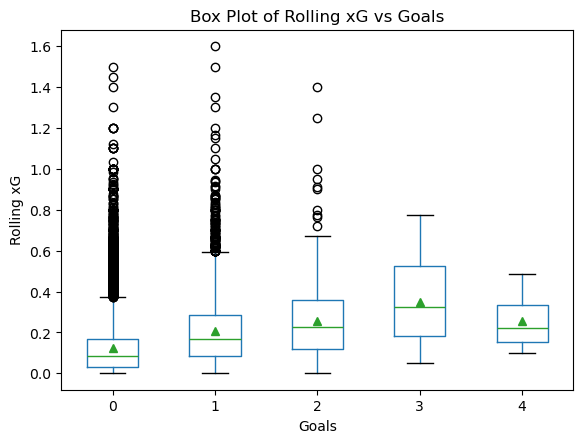

In [225]:
#we need to first remove all rows with NaN in 'Rolling xG' before plotting 
plot_df = feature_explore_df.dropna(subset=['Rolling xG'])

grouped_boxplot(plot_df, 'Rolling xG', 'Goals')

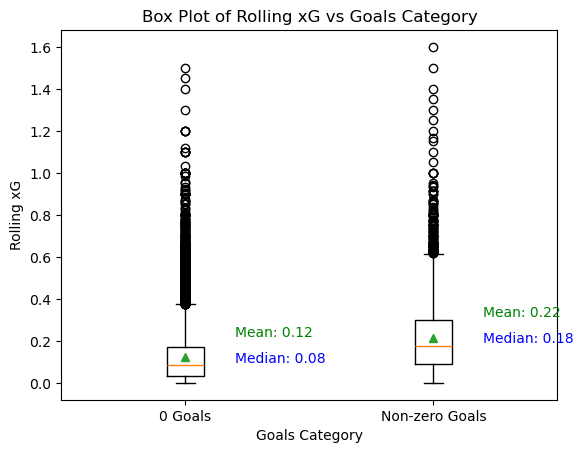

In [226]:
category_boxplot(plot_df, 'Rolling xG', 'Goals', text_diff= 0.15)

What we can see based on these plots is that the positive relationship between Goals and Rolling xG is still present. However, we can also see that there a large number of observations are presenting as outliers. This is because rolling xG is bound to be a noisier feature than just looking at xG by itself. Consider a player who doesn't often record good xG numbers, meaning their rolling xG is quite low. In the off chance that they score a goal, they will have done so with a low rolling xG number. This will drag down the central tendancy of rolling xG for observations with 1 goal. Likewise, there will be players that consistently record good xG numbers (meaning their rolling xG values are quite high), but even these players cannot score in every single game. These represent the observations that have high rolling xG numbers, but are part of the 'no goals' category. 

### Team/Opponent Strength

Using the same idea as above, we can also try to introduce features that coarsely try to categorise team and opponent strength. We can do this by calculating xG rankings for teams, that dynamically change across the season. The rankings will be based on the average xG accumulated by each team throughout the season (similar to how rolling xG works). We will then have features that correspond to both the rolling xG and xGA for each team, as well as the xG and xGA rankings. To do this, we first need to scrape team data from FBref. 

In [230]:
att_final['Team'].unique()

array(['Crystal Palace', 'Bournemouth', 'Huddersfield', 'Southampton',
       'Manchester City', 'Liverpool', 'Manchester Utd', 'Fulham',
       'Arsenal', 'Norwich City', 'Brighton', 'Leicester City',
       'Newcastle Utd', 'Luton Town', 'West Ham', 'Leeds United',
       'Tottenham', "Nott'ham Forest", 'Sheffield Utd', 'Aston Villa',
       'West Brom', 'Everton', 'Burnley', 'Cardiff City', 'Watford',
       'Chelsea', 'Wolves', 'Brentford', 'Swansea City', 'Stoke City'],
      dtype=object)